# Perkenalan

# Import Library

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

# Data Loading

In [8]:
images_dir = 'Dataset/train/images'
labels_dir = 'Dataset/train/labels'

In [3]:
classes_path = 'Dataset/classes.txt'

with open(classes_path, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

print("Class Names:")
for idx, class_name in enumerate(classes):
    print(f"{idx}: {class_name}")


Class Names:
0: Bus
1: Car
2: LicensePlate
3: Motorcycle
4: Truck


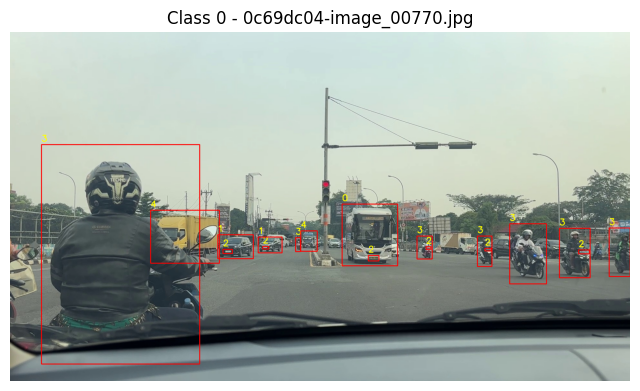

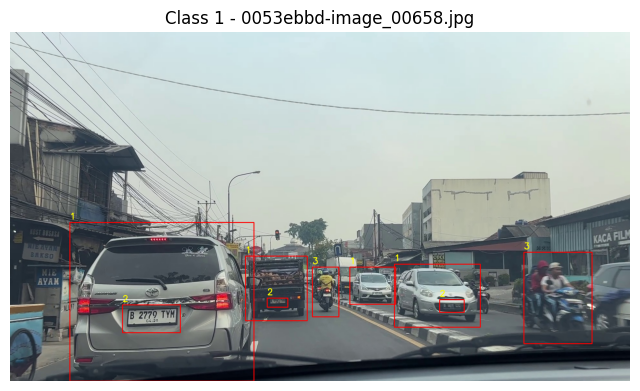

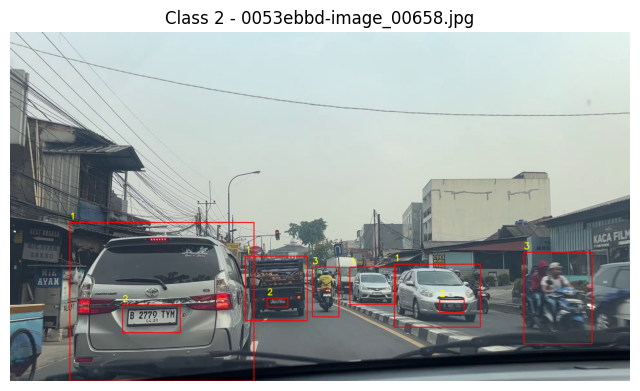

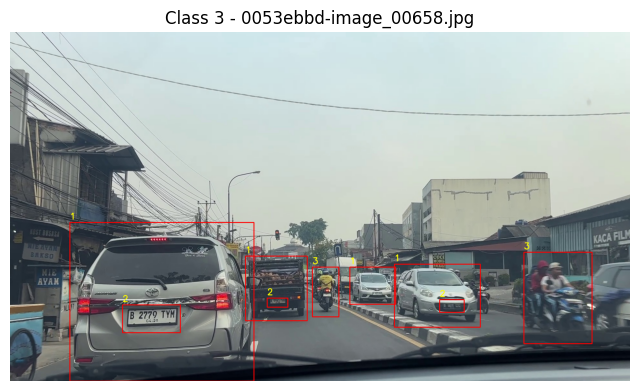

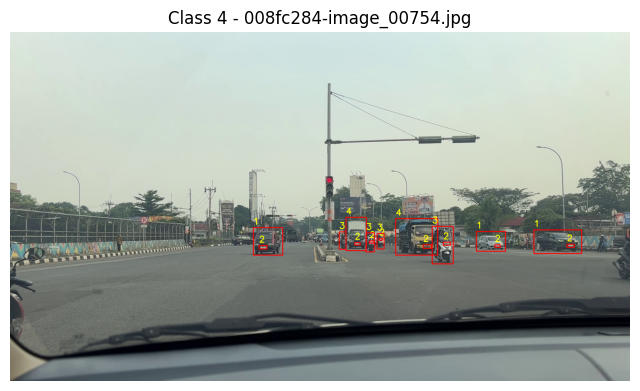

In [4]:
num_classes = 5
class_examples = dict()  # Simpan image_file per class

image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

for image_file in image_files:
    label_file = image_file.replace('.jpg', '.txt')
    label_path = os.path.join(labels_dir, label_file)

    if not os.path.exists(label_path):
        continue

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])

            if class_id not in class_examples and class_id < num_classes:
                class_examples[class_id] = image_file

    if len(class_examples) == num_classes:
        break

for class_id in sorted(class_examples.keys()):
    image_file = class_examples[class_id]
    image_path = os.path.join(images_dir, image_file)
    label_file = image_file.replace('.jpg', '.txt')
    label_path = os.path.join(labels_dir, label_file)

    image = cv2.imread(image_path)
    if image is None:
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    boxes = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            cid = int(parts[0])
            x_center = float(parts[1]) * w
            y_center = float(parts[2]) * h
            width = float(parts[3]) * w
            height = float(parts[4]) * h

            xmin = int(x_center - width / 2)
            ymin = int(y_center - height / 2)
            xmax = int(x_center + width / 2)
            ymax = int(y_center + height / 2)

            boxes.append((cid, xmin, ymin, xmax, ymax))

    for box in boxes:
        cid, xmin, ymin, xmax, ymax = box
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

        label_text = str(cid)
        cv2.putText(image, label_text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.9, (255, 255, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Class {class_id} - {image_file}")
    plt.axis('off')
    plt.show()

# Exploratory Data Analysis

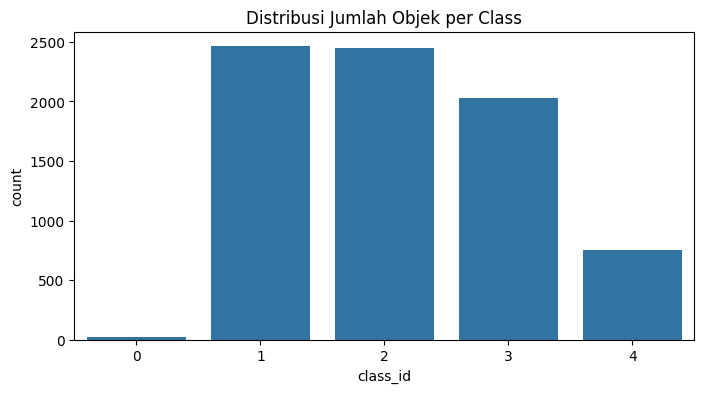

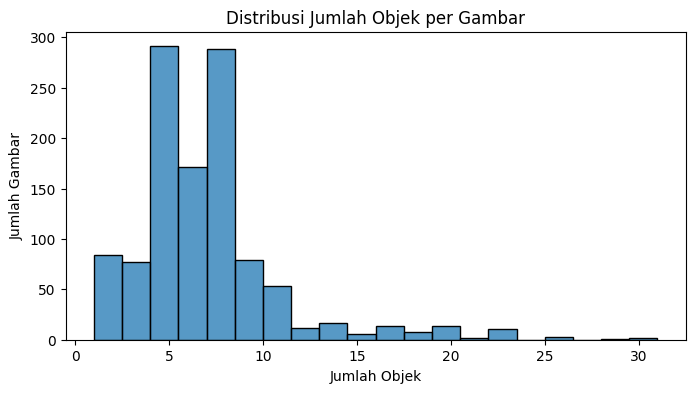

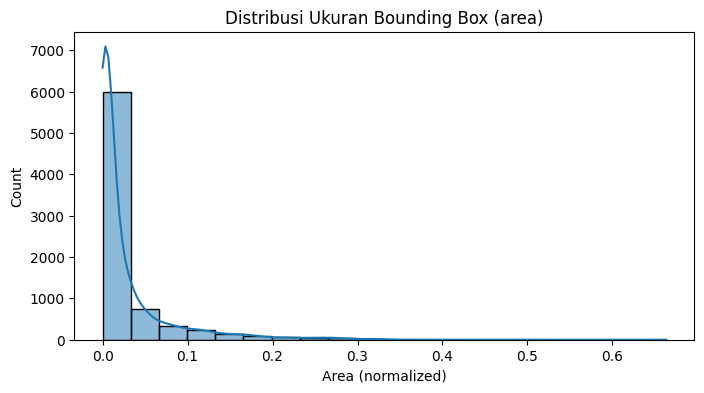

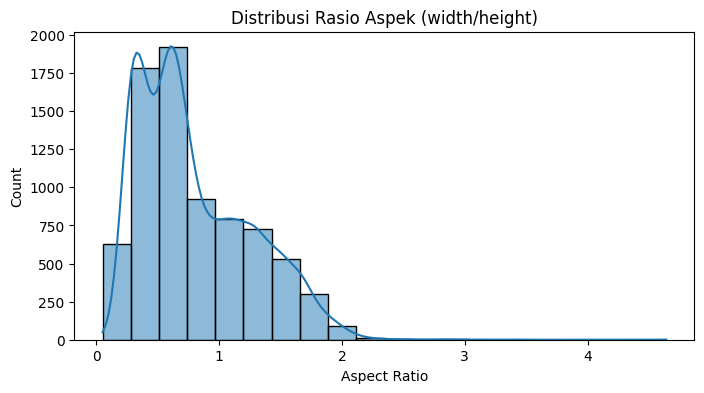

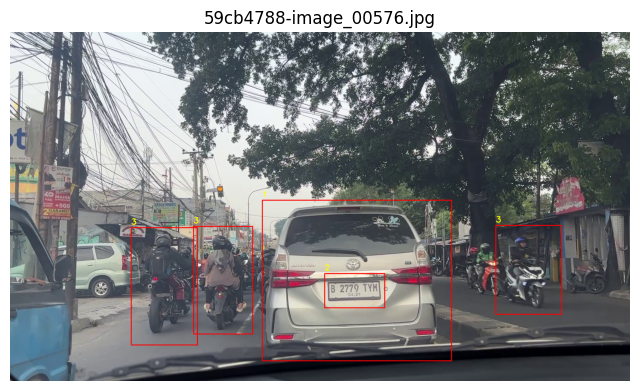

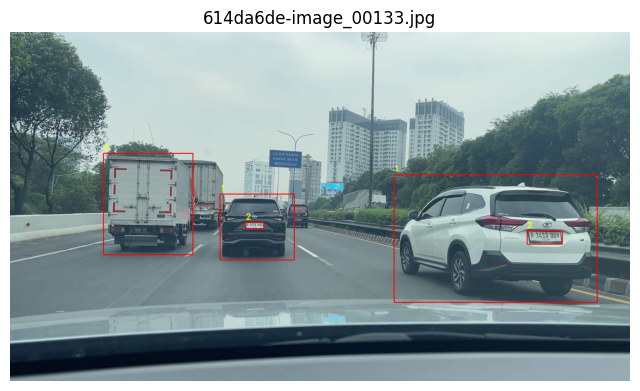

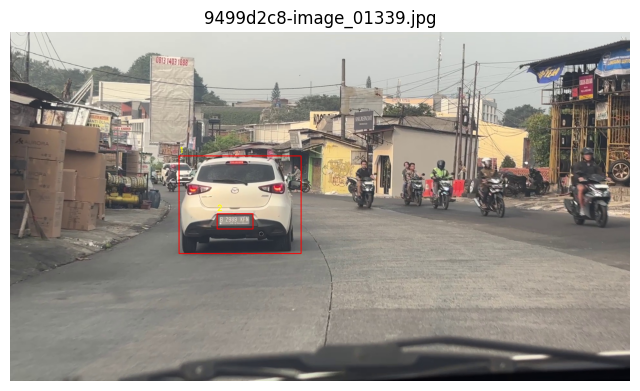

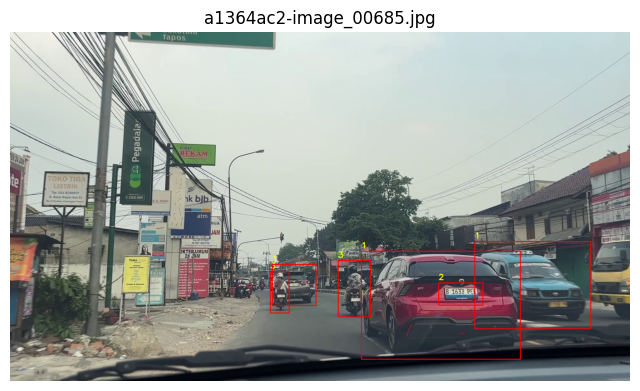

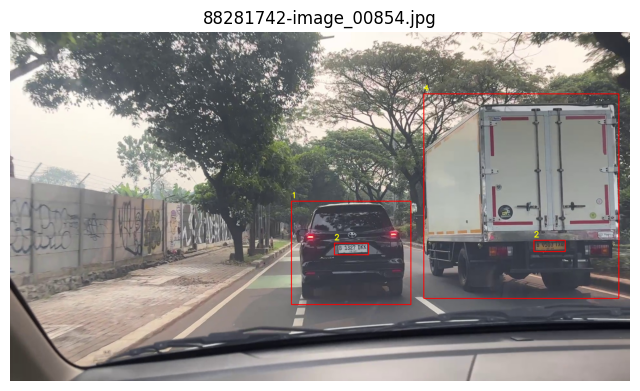

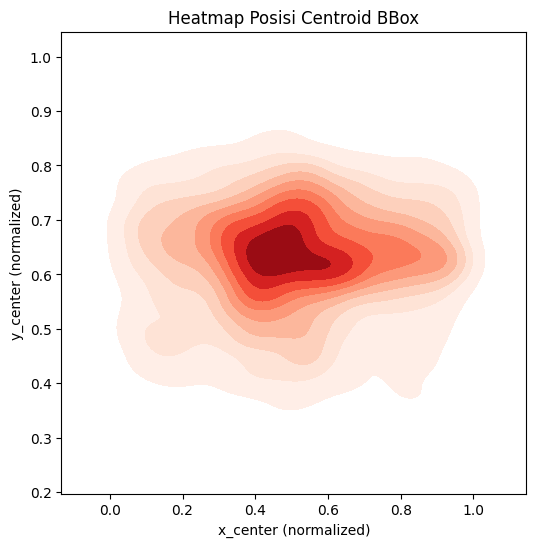

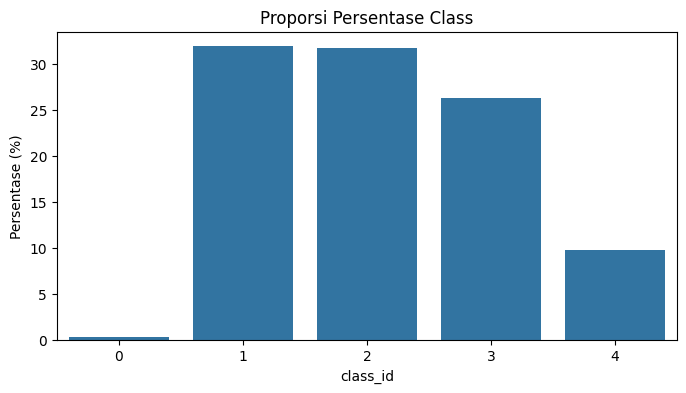

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

records = []

image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
for image_file in image_files:
    image_path = os.path.join(images_dir, image_file)
    label_file = image_file.replace('.jpg', '.txt')
    label_path = os.path.join(labels_dir, label_file)

    if not os.path.exists(label_path):
        continue

    image = plt.imread(image_path)
    h, w = image.shape[:2]

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            records.append({
                'image': image_file,
                'class_id': class_id,
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height,
                'area': width * height,
                'aspect_ratio': width / height if height != 0 else 0
            })

df = pd.DataFrame(records)

# 1️⃣ Distribusi jumlah objek per class
plt.figure(figsize=(8,4))
sns.countplot(x='class_id', data=df)
plt.title('Distribusi Jumlah Objek per Class')
plt.show()

# 2️⃣ Distribusi jumlah objek per gambar
obj_per_image = df.groupby('image').size()
plt.figure(figsize=(8,4))
sns.histplot(obj_per_image, bins=20, kde=False)
plt.title('Distribusi Jumlah Objek per Gambar')
plt.xlabel('Jumlah Objek')
plt.ylabel('Jumlah Gambar')
plt.show()

# 3️⃣ Distribusi ukuran bbox (area)
plt.figure(figsize=(8,4))
sns.histplot(df['area'], bins=20, kde=True)
plt.title('Distribusi Ukuran Bounding Box (area)')
plt.xlabel('Area (normalized)')
plt.show()

# 4️⃣ Distribusi rasio aspek bbox
plt.figure(figsize=(8,4))
sns.histplot(df['aspect_ratio'], bins=20, kde=True)
plt.title('Distribusi Rasio Aspek (width/height)')
plt.xlabel('Aspect Ratio')
plt.show()

# 5️⃣ Visualisasi 5 gambar random + bbox
import cv2
sample_images = df['image'].unique()
sample_images = np.random.choice(sample_images, size=min(5, len(sample_images)), replace=False)

for image_file in sample_images:
    image_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    boxes = df[df['image']==image_file]
    for _, row in boxes.iterrows():
        xmin = int((row['x_center'] - row['width']/2) * w)
        ymin = int((row['y_center'] - row['height']/2) * h)
        xmax = int((row['x_center'] + row['width']/2) * w)
        ymax = int((row['y_center'] + row['height']/2) * h)
        class_id = row['class_id']

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
        cv2.putText(image, str(class_id), (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,0), 2)

    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.title(image_file)
    plt.axis('off')
    plt.show()

# 6️⃣ Heatmap sebaran posisi centroid bbox
plt.figure(figsize=(6,6))
sns.kdeplot(x=df['x_center'], y=df['y_center'], fill=True, cmap='Reds')
plt.title('Heatmap Posisi Centroid BBox')
plt.xlabel('x_center (normalized)')
plt.ylabel('y_center (normalized)')
plt.show()

# 7️⃣ Proporsi persentase class
class_counts = df['class_id'].value_counts(normalize=True) * 100
plt.figure(figsize=(8,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Proporsi Persentase Class')
plt.ylabel('Persentase (%)')
plt.show()


In [6]:
from ultralytics import YOLO

# Load model YOLOv8 pretrained (misal YOLOv8n = nano, bisa diganti v8s/v8m/v8l)
model = YOLO('yolov8n.pt')

# Train
model.train(
    data='Dataset/data.yaml',
    epochs=50, 
    batch=16,
    imgsz=640, 
    device='0', 
    patience=5          
)

New https://pypi.org/project/ultralytics/8.3.166 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.165  Python-3.9.23 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, opti

train: Scanning C:\Vike Data\4. Study\Hacktiv8\Final Project\Dataset\train\labels... 1155 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1155/1155 [00:00<00:00, 1832.35it/s]


train: New cache created: C:\Vike Data\4. Study\Hacktiv8\Final Project\Dataset\train\labels.cache
val: Fast image access  (ping: 0.80.3 ms, read: 15.26.7 MB/s, size: 549.8 KB)


val: Scanning C:\Vike Data\4. Study\Hacktiv8\Final Project\Dataset\val\labels... 288 images, 1 backgrounds, 0 corrupt: 100%|██████████| 288/288 [00:02<00:00, 133.74it/s]

val: C:\Vike Data\4. Study\Hacktiv8\Final Project\Dataset\val\images\fb23bedb-image_00763.jpg: 1 duplicate labels removed
val: New cache created: C:\Vike Data\4. Study\Hacktiv8\Final Project\Dataset\val\labels.cache


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.16G      1.395      2.194      1.139         30        640: 100%|██████████| 73/73 [00:19<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.31it/s]

                   all        288       1998      0.958      0.174      0.466      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.16G      1.271      1.238      1.084         34        640: 100%|██████████| 73/73 [00:14<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.80it/s]

                   all        288       1998      0.791      0.485      0.548      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.19G      1.249      1.136      1.078         12        640: 100%|██████████| 73/73 [00:13<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.62it/s]

                   all        288       1998      0.797      0.582      0.642      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.21G      1.214      1.059      1.066         56        640: 100%|██████████| 73/73 [00:13<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]

                   all        288       1998      0.674      0.602      0.642      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.22G       1.19      0.987      1.054         52        640: 100%|██████████| 73/73 [00:13<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.72it/s]

                   all        288       1998      0.732      0.634      0.678       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.23G      1.194       0.96      1.059         55        640: 100%|██████████| 73/73 [00:13<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]

                   all        288       1998      0.822      0.617      0.697      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.26G      1.159     0.9066      1.045         31        640: 100%|██████████| 73/73 [00:13<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.91it/s]

                   all        288       1998      0.791      0.638      0.709      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.28G      1.151     0.8775      1.032         26        640: 100%|██████████| 73/73 [00:13<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]

                   all        288       1998      0.813      0.679      0.717      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.29G      1.136     0.8444      1.026         52        640: 100%|██████████| 73/73 [00:15<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.53it/s]

                   all        288       1998      0.817      0.677      0.731      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       2.3G      1.111      0.808       1.02         37        640: 100%|██████████| 73/73 [00:13<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]

                   all        288       1998      0.783      0.682      0.744      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.33G       1.11     0.7914      1.023         30        640: 100%|██████████| 73/73 [00:13<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]

                   all        288       1998      0.804      0.665      0.722      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.34G      1.089     0.7722       1.01         35        640: 100%|██████████| 73/73 [00:13<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]

                   all        288       1998      0.878      0.666      0.737       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.36G      1.073     0.7442      1.004         34        640: 100%|██████████| 73/73 [00:15<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]

                   all        288       1998      0.859      0.666       0.74      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.37G      1.071     0.7335      1.005         56        640: 100%|██████████| 73/73 [00:14<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.90it/s]

                   all        288       1998      0.799      0.682      0.726      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       2.4G      1.078     0.7349      1.007         12        640: 100%|██████████| 73/73 [00:13<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.92it/s]

                   all        288       1998      0.765      0.706      0.743      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.41G      1.064     0.7164          1         73        640: 100%|██████████| 73/73 [00:13<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.05it/s]

                   all        288       1998      0.816       0.74      0.763      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.43G      1.048      0.708     0.9977         31        640: 100%|██████████| 73/73 [00:14<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.40it/s]

                   all        288       1998      0.819       0.69      0.756      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.44G      1.055     0.6978      1.003         78        640: 100%|██████████| 73/73 [00:14<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.97it/s]

                   all        288       1998      0.849       0.69      0.756      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.47G      1.034     0.6777     0.9915         19        640: 100%|██████████| 73/73 [00:13<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]

                   all        288       1998      0.814      0.701      0.763      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.48G      1.036     0.6785     0.9933         46        640: 100%|██████████| 73/73 [00:13<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]

                   all        288       1998      0.821      0.697      0.759      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       2.5G      1.038     0.6646     0.9884         19        640: 100%|██████████| 73/73 [00:13<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.95it/s]

                   all        288       1998      0.872      0.713      0.772      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.51G      1.015     0.6478     0.9816         16        640: 100%|██████████| 73/73 [00:14<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]

                   all        288       1998      0.809      0.713      0.772      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.53G      1.007     0.6478     0.9833         21        640: 100%|██████████| 73/73 [00:13<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]

                   all        288       1998      0.803      0.702      0.764      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.55G      1.016     0.6436     0.9872         27        640: 100%|██████████| 73/73 [00:13<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.91it/s]

                   all        288       1998      0.786      0.742      0.754      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.57G     0.9941     0.6234     0.9755         49        640: 100%|██████████| 73/73 [00:13<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.01it/s]

                   all        288       1998      0.818      0.696      0.751      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.58G     0.9854     0.6265     0.9753         12        640: 100%|██████████| 73/73 [00:13<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]

                   all        288       1998      0.841      0.751      0.789       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       2.6G     0.9763     0.6101     0.9701         38        640: 100%|██████████| 73/73 [00:13<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.90it/s]

                   all        288       1998       0.83      0.703      0.774      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.62G     0.9764     0.6159     0.9706         37        640: 100%|██████████| 73/73 [00:13<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.05it/s]

                   all        288       1998      0.847      0.698      0.781      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.63G     0.9857     0.6095     0.9726         47        640: 100%|██████████| 73/73 [00:13<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]

                   all        288       1998      0.817      0.729      0.785      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.64G     0.9745     0.5995     0.9699         41        640: 100%|██████████| 73/73 [00:13<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]

                   all        288       1998       0.82      0.718      0.774      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.67G      0.967     0.5905     0.9637         25        640: 100%|██████████| 73/73 [00:13<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.62it/s]

                   all        288       1998      0.828      0.711      0.778      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.69G     0.9627     0.5828     0.9597         18        640: 100%|██████████| 73/73 [00:13<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]

                   all        288       1998       0.83      0.714      0.771       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       2.7G     0.9528     0.5744      0.959         43        640: 100%|██████████| 73/73 [00:13<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]

                   all        288       1998      0.851      0.733      0.795      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.71G     0.9548     0.5698     0.9621         25        640: 100%|██████████| 73/73 [00:13<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]

                   all        288       1998       0.85      0.711      0.782       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.74G     0.9437     0.5708     0.9527         43        640: 100%|██████████| 73/73 [00:13<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.06it/s]

                   all        288       1998      0.837      0.707      0.773      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.75G     0.9284     0.5587     0.9531         50        640: 100%|██████████| 73/73 [00:13<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]

                   all        288       1998      0.854        0.7       0.78      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.77G     0.9269     0.5625     0.9563         26        640: 100%|██████████| 73/73 [00:13<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.08it/s]

                   all        288       1998      0.824      0.728      0.773       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.78G     0.9253      0.551     0.9524         46        640: 100%|██████████| 73/73 [00:13<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]

                   all        288       1998      0.807      0.757      0.793      0.554
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 33, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



38 epochs completed in 0.177 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 6.2MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.165  Python-3.9.23 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


                   all        288       1998      0.852      0.733      0.796      0.557
                   Bus         10         12      0.684      0.417       0.52      0.373
                   Car        257        600        0.9      0.927      0.957      0.732
          LicensePlate        254        647      0.883      0.583      0.666      0.353
            Motorcycle        205        588      0.879       0.82      0.892      0.574
                 Truck         88        151      0.914      0.921      0.942      0.751
Speed: 0.2ms preprocess, 1.7ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs\detect\train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000018C9ACE8E20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
    


0: 384x640 5 Cars, 3 LicensePlates, 3 Motorcycles, 58.5ms
Speed: 6.6ms preprocess, 58.5ms inference, 5.1ms postprocess per image at shape (1, 3, 384, 640)


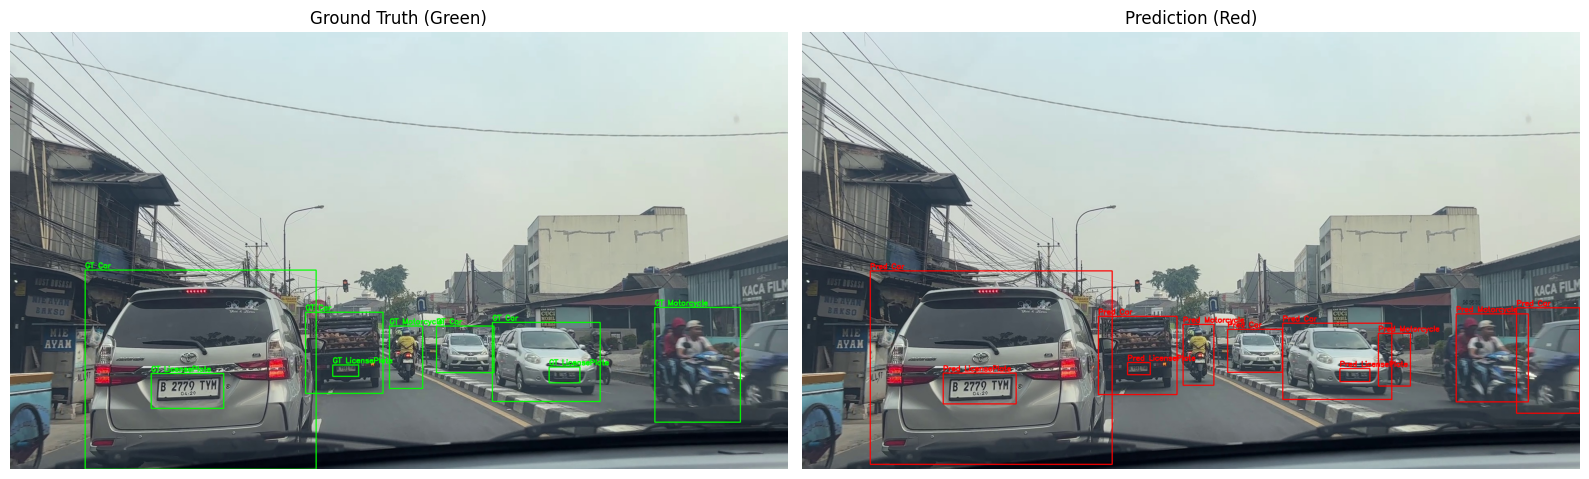


0: 384x640 3 Cars, 4 Motorcycles, 2 Trucks, 18.8ms
Speed: 4.2ms preprocess, 18.8ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)


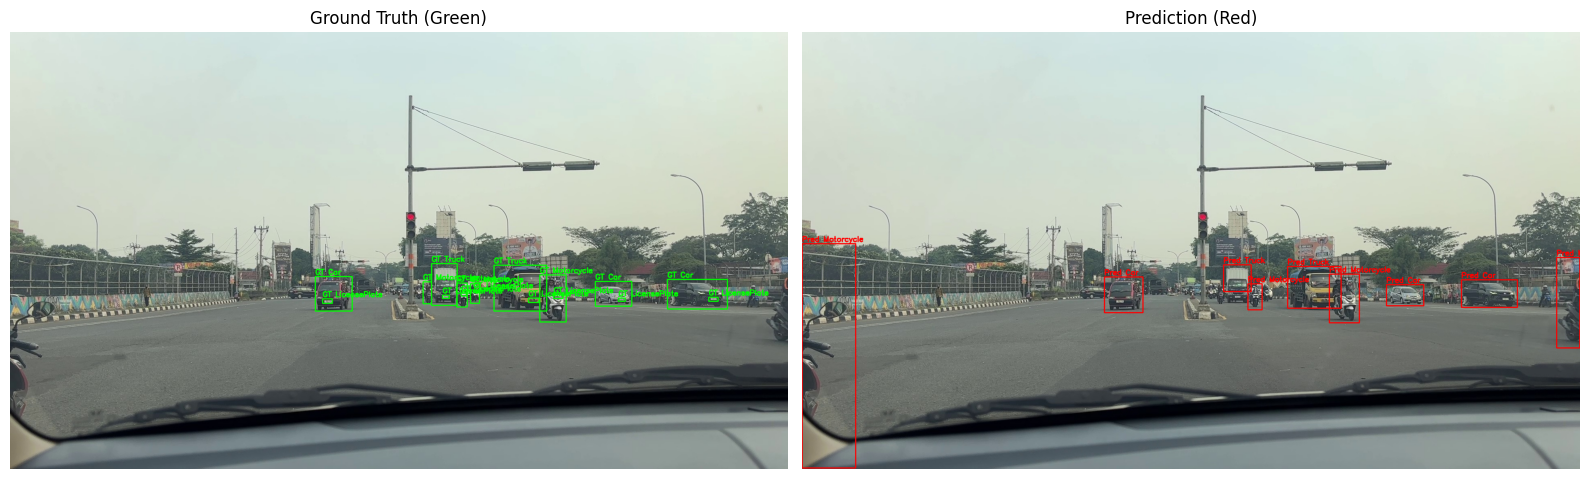


0: 384x640 1 Car, 1 LicensePlate, 6 Motorcycles, 17.4ms
Speed: 5.1ms preprocess, 17.4ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)


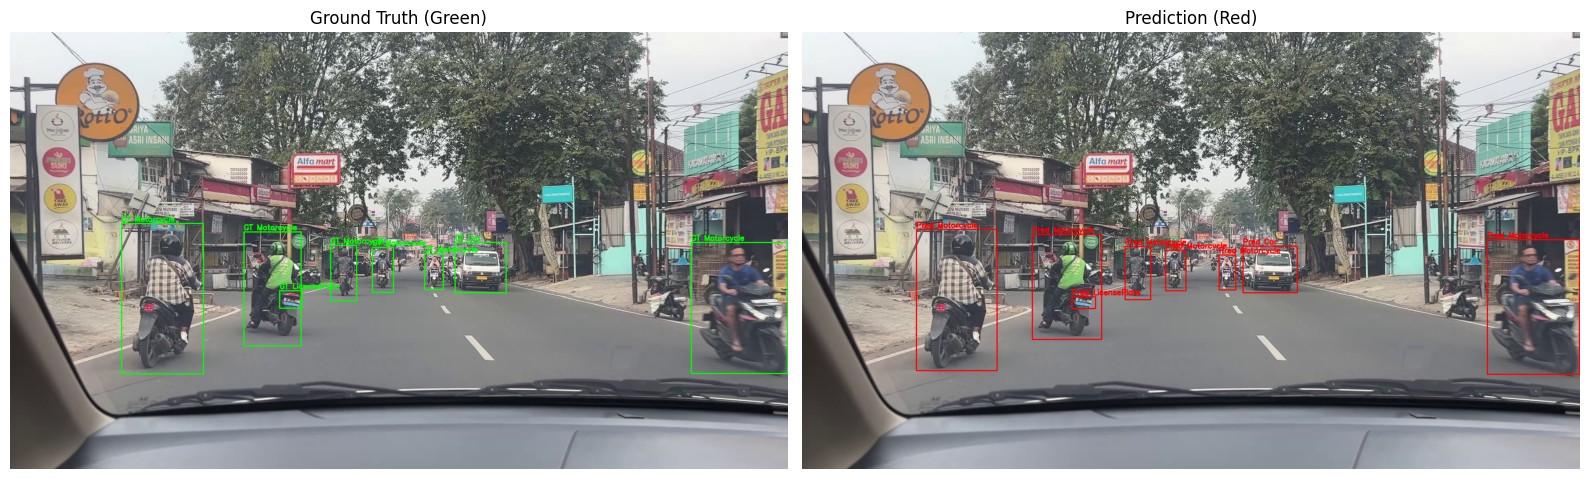


0: 384x640 2 Cars, 2 LicensePlates, 2 Trucks, 27.3ms
Speed: 4.2ms preprocess, 27.3ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)


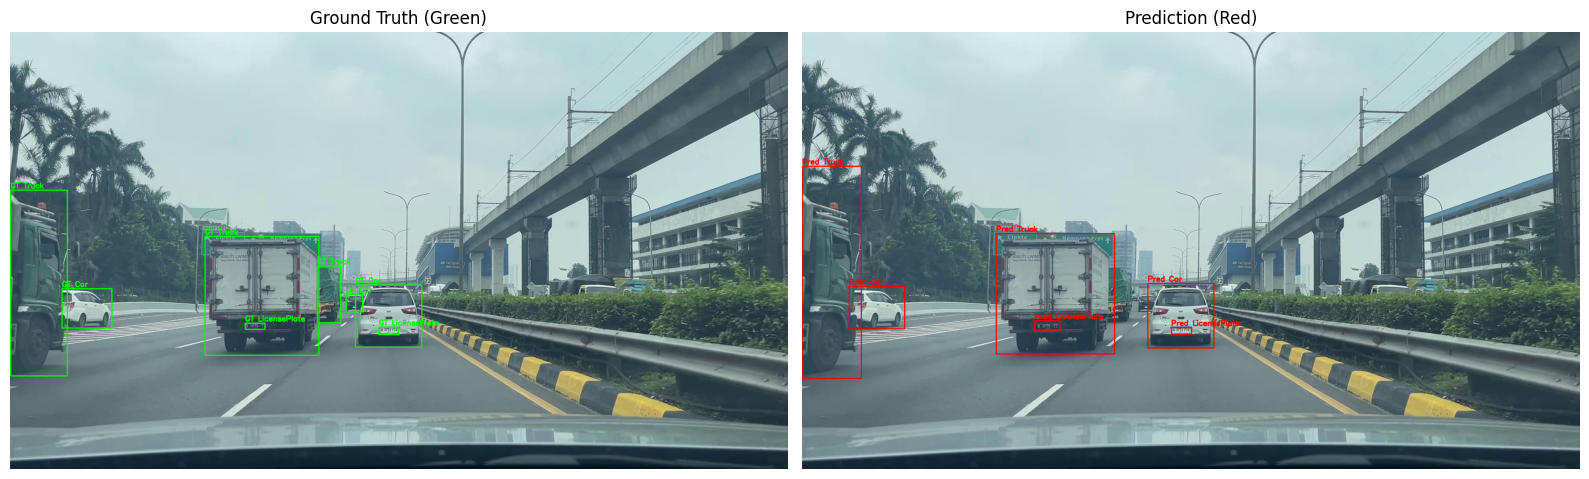


0: 384x640 1 Car, 2 LicensePlates, 4 Motorcycles, 22.1ms
Speed: 4.1ms preprocess, 22.1ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)


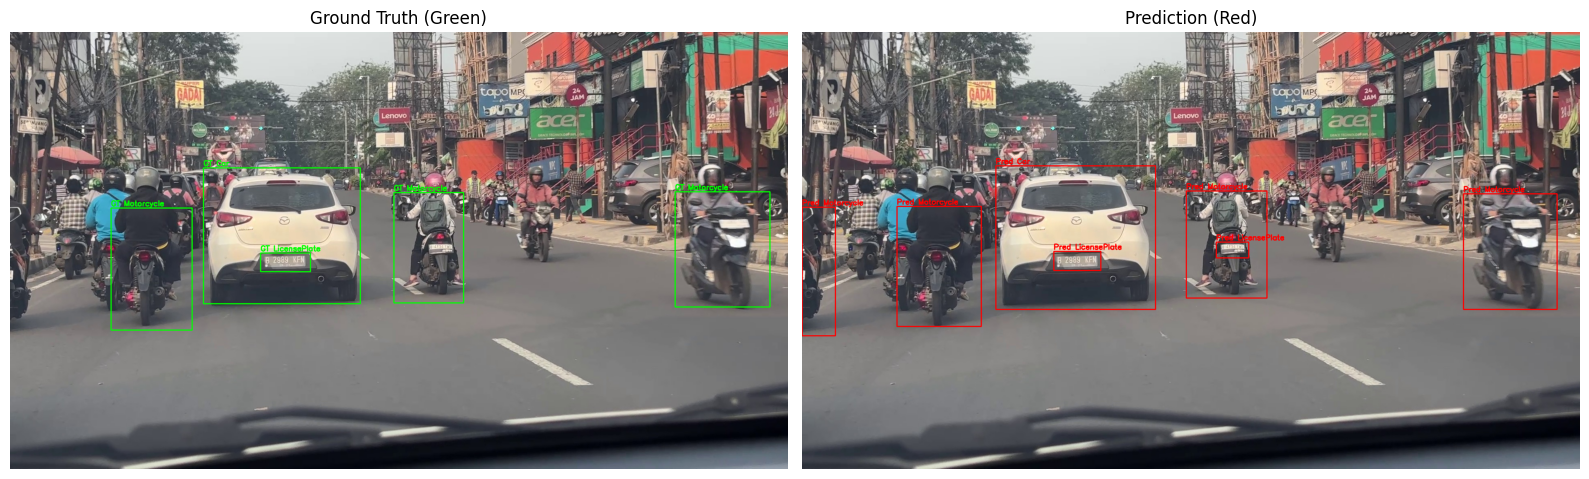

In [10]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# === Paths ===
model_path = 'runs/detect/train2/weights/best.pt'

# === Load model ===
model = YOLO(model_path)

# === Helper: load actual labels ===
def load_actual_boxes(label_path, img_width, img_height):
    boxes = []
    with open(label_path, 'r') as file:
        for line in file:
            cls, x_center, y_center, w, h = map(float, line.strip().split())
            # Convert from YOLO format to box coordinates
            x1 = int((x_center - w/2) * img_width)
            y1 = int((y_center - h/2) * img_height)
            x2 = int((x_center + w/2) * img_width)
            y2 = int((y_center + h/2) * img_height)
            boxes.append((int(cls), x1, y1, x2, y2))
    return boxes

# === Visualize a few predictions ===
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')][:5]  # Limit to 5 for display

for image_file in image_files:
    img_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))

    # Load image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Get actual boxes
    actual_boxes = load_actual_boxes(label_path, w, h)

    # Get predictions
    results = model(img_rgb)[0]
    pred_boxes = []
    for box in results.boxes:
        cls = int(box.cls[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        pred_boxes.append((cls, x1, y1, x2, y2))

    # Draw both images
    img_actual = img_rgb.copy()
    img_pred = img_rgb.copy()

    # Draw actual boxes in GREEN
    for cls, x1, y1, x2, y2 in actual_boxes:
        cv2.rectangle(img_actual, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_actual, f"GT {classes[cls]}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    # Draw predicted boxes in RED
    for cls, x1, y1, x2, y2 in pred_boxes:
        cv2.rectangle(img_pred, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img_pred, f"Pred {classes[cls]}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

    # Display side by side
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs[0].imshow(img_actual)
    axs[0].set_title("Ground Truth (Green)")
    axs[0].axis('off')

    axs[1].imshow(img_pred)
    axs[1].set_title("Prediction (Red)")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# DOESNT WORK
# Load best trained model
"""model = YOLO('runs/detect/train/weights/best.pt')

metrics = model.val(split='test') 

# Optional: print key metrics
print("mAP50-95:", metrics.box.map) 
print("Precision:", metrics.box.precision)
print("Recall:", metrics.box.recall)"""

Ultralytics 8.3.165  Python-3.9.23 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.30.2 ms, read: 44.111.1 MB/s, size: 469.8 KB)


val: Scanning C:\Vike Data\4. Study\Hacktiv8\Final Project\Dataset\test\labels... 162 images, 0 backgrounds, 0 corrupt: 100%|██████████| 162/162 [00:00<00:00, 424.92it/s]


val: New cache created: C:\Vike Data\4. Study\Hacktiv8\Final Project\Dataset\test\labels.cache
